In [5]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2018', '2017']
var_dict = [{}, {}, {}]
df = []
for year in years:
  print(f'Processing {year}')
  result = load(f"../results/{year}/makeDF/output_noiso.coffea")
  if isinstance(result,tuple):
      result = result[0]
  for varName in result:
    for i in range(3):
      if f'{i}jets' in varName:
        if varName.replace(f'_{i}jets','') in var_dict[i]:
          var_dict[i][varName.replace(f'_{i}jets','')] = np.append(var_dict[i][varName.replace(f'_{i}jets','')],result[varName].value)
        else:
          var_dict[i][varName.replace(f'_{i}jets','')] = result[varName].value
for i in range(3):
    df.append(pd.DataFrame(var_dict[i]))

Processing 2018
Processing 2017


In [6]:
data_cuts_os = []
for i in range(2):
    massRange = (((df[i]['e_m_Mass']>110)&(df[i]['e_m_Mass']<115)) | ((df[i]['e_m_Mass']>135)&(df[i]['e_m_Mass']<160)))
    typeofSamples = (df[i]['label']==3)
    data_cuts_os.append(df[i][(df[i]['opp_charge']==1) & ((massRange & typeofSamples) | (df[i]['label']==1) | (df[i]['label']==0))])

massRange = (((df[2]['e_m_Mass']>110)&(df[2]['e_m_Mass']<115)) | ((df[2]['e_m_Mass']>135)&(df[2]['e_m_Mass']<160)))
typeofSamples = (df[2]['label']==3)
data_cuts_os.append(df[2][((massRange & typeofSamples) | (df[2]['label']==1) | (df[2]['label']==0)) & (df[2]['isVBFcat']==0) & (df[2]['opp_charge']==1)])
data_cuts_os.append(df[2][((massRange & typeofSamples) | (df[2]['label']==1) | (df[2]['label']==0)) & (df[2]['isVBFcat']==1) & (df[2]['opp_charge']==1)])
data_cuts_ss = []
for i in range(2):
    massRange = (df[i]['e_m_Mass']>110)&(df[i]['e_m_Mass']<160)
    typeofSamples = (df[i]['label']==0) | (df[i]['label']==3)
    data_cuts_ss.append(df[i][(df[i]['opp_charge']!=1) & massRange & typeofSamples])

massRange = (df[2]['e_m_Mass']>110)&(df[2]['e_m_Mass']<160)
typeofSamples = ((df[2]['label']==0) | (df[2]['label']==3))
data_cuts_ss.append(df[2][massRange & typeofSamples & (df[2]['isVBFcat']==0) & (df[2]['opp_charge']!=1)])
data_cuts_ss.append(df[2][massRange & typeofSamples & (df[2]['isVBFcat']==1) & (df[2]['opp_charge']!=1)])

In [7]:
from coffea import hist
dataset_axis = hist.Cat("dataset", "samples")
dict_of_hists = []
ncats = 4
for i in range(ncats):
    dict_of_hists.append(hist.Hist("Events", dataset_axis, hist.Bin("e_m_Mass", '$m_{e\mu}$ [GeV]', 50, 110, 160)))

In [8]:
#!ln -s /afs/crc.nd.edu/user/k/kho2/Flavour-Violating-Coffea/find_samples.py find_samples.py
#import find_samples
samples = ['data', 'GluGlu_LFV_HToEMu_M125', 'VBF_LFV_HToEMu_M125', 'TTTo2L2Nu', 'GluGlu_LFV_HToEMu_M120', 'VBF_LFV_HToEMu_M120', 'GluGlu_LFV_HToEMu_M130', 'VBF_LFV_HToEMu_M130', 'ZZ_TuneCP5', 'WZ_TuneCP5', 'WW_TuneCP5', 'DYJetsToLL_M-50', 'DYJetsToLL_M-10to50', 'WGToLNuG_TuneCP5', 'TTToSemiLeptonic', 'TTToHadronic', 'ST_tW_antitop_5f_inclusiveDecays', 'ST_tW_top_5f_inclusiveDecays', 'ST_t-channel_antitop_5f_inclusiveDecays', 'ST_t-channel_top_5f_InclusiveDecays', 'EWKZ2Jets_ZToLL', 'EWKZ2Jets_ZToNuNu', 'EWKWMinus2Jets', 'EWKWPlus2Jets', 'GluGluHToTauTau', 'VBFHToTauTau', 'WminusHToTauTau', 'WplusHToTauTau', 'GluGluHToWWTo2L2Nu', 'VBFHToWWTo2L2Nu', 'ZHToTauTau', 'WJetsToLNu_TuneCP5', 'W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu', 'W4JetsToLNu']

signal_scale = 0.5
sample_group = []

for i in samples:
    sample_group_name = ''
    if "TT" in i:
        sample_group_name = r'$t\bar{t}$'
    elif "ST" in i:
        sample_group_name = r't+Jets'
    elif "LFV" in i:
        sample_group_name = r'$H\rightarrow e\mu$ (BR=1%)'
    elif "HTo" in i:
        sample_group_name = 'SM Higgs'
    elif "ZZ" in i or "WZ" in i  or "WW" in i:
        sample_group_name = "Diboson"
    elif "DY" in i:
        sample_group_name = "DY+Jets"
    elif "JetsToLNu" in i or "WG" in i:
        sample_group_name = "W+Jets"
    elif "EWK" in i:
        sample_group_name = "EWK W/Z"
    elif "data" in i:
        sample_group_name = "data"
    sample_group.append(sample_group_name)
sample_group = np.array(sample_group)

for i in range(ncats):
    data_cuts_os[i]['sample_name'] = sample_group.take(data_cuts_os[i]['sample'].to_numpy().astype(int))
    data_cuts_ss[i]['sample_name'] = sample_group.take(data_cuts_ss[i]['sample'].to_numpy().astype(int))

subset_os, subset_ss = {}, {}
for groupName in sample_group:
    subset_os[groupName], subset_ss[groupName] = [], []
    for i in range(ncats):
        subset_os[groupName].append(data_cuts_os[i][data_cuts_os[i]['sample_name']==groupName])
        subset_ss[groupName].append(data_cuts_ss[i][data_cuts_ss[i]['sample_name']==groupName])

for i in range(ncats):
    print(f'Plotting {i} jets Variables')
    for groupName in list(dict.fromkeys(sample_group)):
        if groupName==r'$H\rightarrow e\mu$ (BR=1%)': 
            arg = {"e_m_Mass": subset_os[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': groupName, 'weight': 0.2*subset_os[groupName][i]['weight'].to_numpy()}
        else:
            arg = {"e_m_Mass": subset_os[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': groupName, 'weight': subset_os[groupName][i]['weight'].to_numpy()}
        dict_of_hists[i].fill(**arg)        
        if groupName=='data':
            arg = {"e_m_Mass": subset_ss[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': 'QCD', 'weight': subset_ss[groupName][i]['weight'].to_numpy()}
            dict_of_hists[i].fill(**arg)
        elif not 'BR' in groupName:
            arg = {"e_m_Mass": subset_ss[groupName][i]['e_m_Mass'].to_numpy(), 'dataset': 'QCD', 'weight': 0-subset_ss[groupName][i]['weight'].to_numpy()}
            dict_of_hists[i].fill(**arg)

/tmp/ipykernel_712458/1542189897.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cuts_os[i]['sample_name'] = sample_group.take(data_cuts_os[i]['sample'].to_numpy().astype(int))
/tmp/ipykernel_712458/1542189897.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cuts_ss[i]['sample_name'] = sample_group.take(data_cuts_ss[i]['sample'].to_numpy().astype(int))


Plotting 0 jets Variables
Plotting 1 jets Variables
Plotting 2 jets Variables
Plotting 3 jets Variables


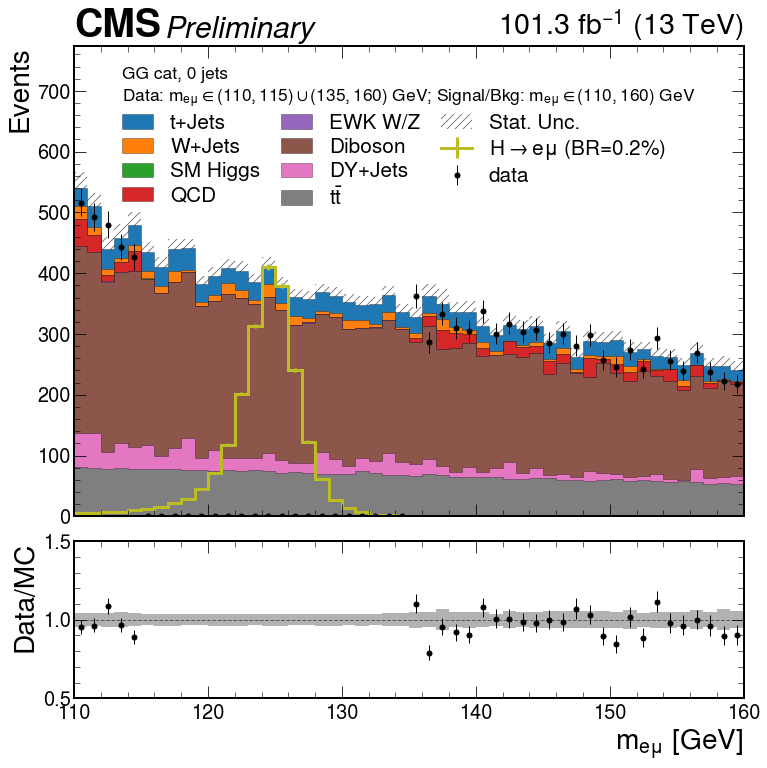

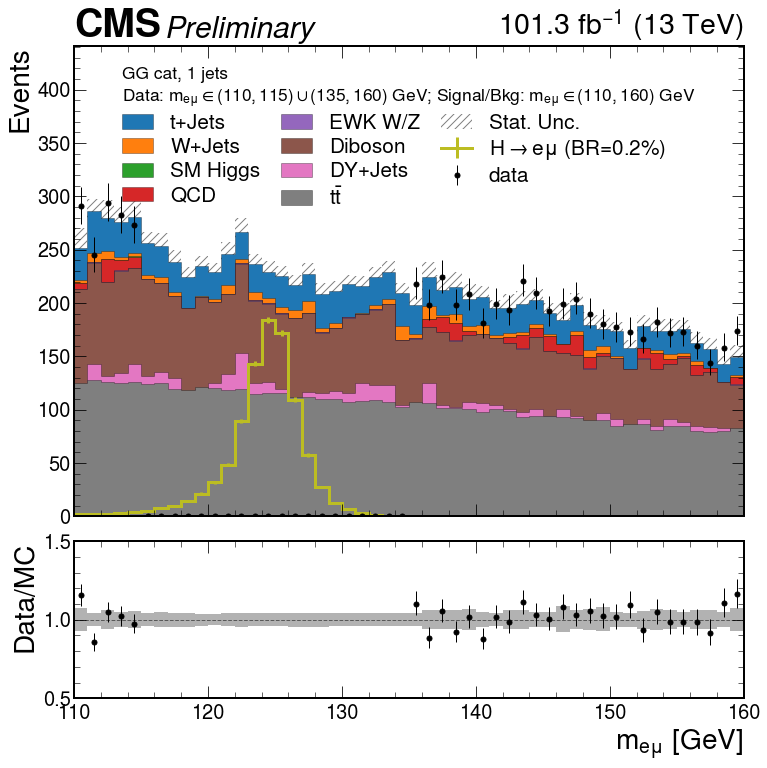

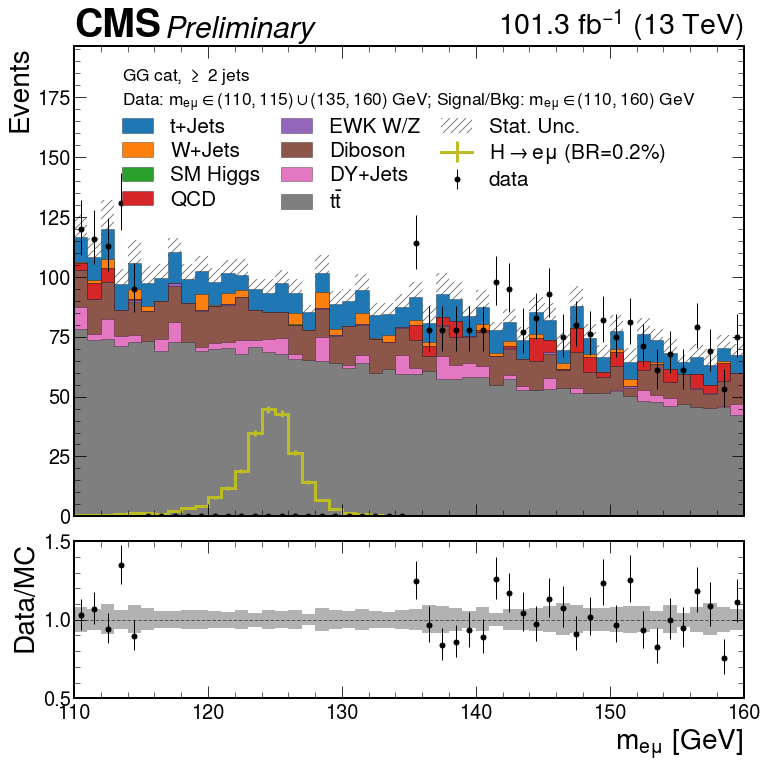

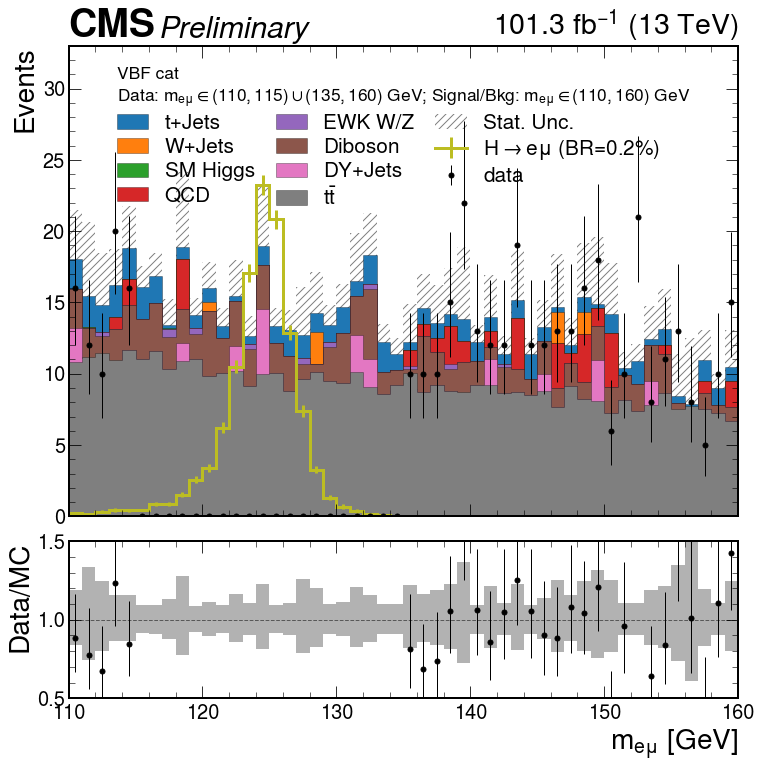

In [9]:
from coffea.util import save, load
from coffea import hist
import math
import mplhep

%matplotlib inline

catlabels = ['GG cat, 0 jets', 'GG cat, 1 jets', 'GG cat, $\geq$ 2 jets', 'VBF cat']

list_of_bkg = [r'$t\bar{t}$', 't+Jets', 'SM Higgs', "DY+Jets", "EWK W/Z", "Diboson", "W+Jets"]#, "QCD"]

xlabel_dict = {
    "$\eta^{j_{1}}$"
}

label_dict = {
    'data': 'data',
    'TTTo2L2Nu': r'$t\bar{t}$',
    'GluGlu_LFV_HToEMu_M125': r'$H\rightarrow e\mu$ (BR=1%)',
    'DYJetsToLL_M-50': r'DY+Jets',
    "Stat. unc.": "Stat. unc."
}

#dict_of_hist, feature_names = dict_of_hists[0], features_lists[0]
#if True:
for icat in range(ncats):
    histo = dict_of_hists[icat] 
    signal_scale = 0.2

    data = histo["data"] 
    bkg = histo[list_of_bkg]
    signal = histo[r'$H\rightarrow e\mu$ (BR=1%)']

    qcd = histo['QCD'].copy()
    (k, v), = histo['QCD']._sumw.items()
    qcd._sumw2[k][qcd._sumw[k]<0] = 0
    qcd._sumw[k][qcd._sumw[k]<0] = 0
    bkg.add(qcd)

    import matplotlib.pyplot as plt
    plt.style.use(mplhep.style.CMS)

    plt.rcParams.update({
        'font.size': 30,
        'axes.titlesize': 24,
        'axes.labelsize': 28,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
    })

    plt.rcParams.update({'lines.linewidth': 3})

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(12,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.08)

    fill_opts = {
        'edgecolor': (0,0,0,0.3),
        #'alpha': 0.8
    }
    error_opts = {
        'label': 'Stat. Unc.',
        'hatch': '///',
        'facecolor': 'none',
        'edgecolor': (0,0,0,.5),
        'linewidth': 0
    }
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }

    hist.plot1d(
        bkg,
        overlay="dataset",
        ax=ax,
        clear=False,
        stack=True,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts
    )

    hist.plot1d(
        signal,
        overlay="dataset",
        ax=ax,
        clear=False,
        line_opts={'linewidth': 3.0},
        error_opts={}
    )

    hist.plot1d(
        data,
        overlay="dataset",
        ax=ax,
        clear=False,
        error_opts=data_err_opts
    )

    ax.autoscale(axis='x', tight=True)

    ax.set_ylim(0, max(data.sum("dataset").values()[()])*1.5)
    ax.set_xlabel(None)

    label_list = []
    for t in ax.get_legend_handles_labels():
        label_list.append(t)
    new_label_list = []
    for txt in label_list[1]:
        if txt[0] == '0':
            txt = str(txt)[:4]
        if txt==r'$H\rightarrow e\mu$ (BR=1%)':
            new_label_list.append(r'$H\rightarrow e\mu$ (BR={:.1f}%)'.format(signal_scale))
        else:
            new_label_list.append(txt)
    label_list[1] = new_label_list
    leg = ax.legend(title_fontsize='xx-small', title=catlabels[icat]+' \nData: $m_{e\mu} \in (110, 115) \cup (135, 160)\ GeV$; Signal/Bkg: $m_{e\mu} \in (110, 160)\ GeV$', fontsize='x-small', ncol=3, columnspacing=1, labelspacing=0.25, loc=9, handles=label_list[0], labels=label_list[1])
    leg._legend_box.align = "left"

#         ax.annotate('GG cat, 0 jet \nData/Bkg: $m_{e\mu} \in (110, 115) \cup (135, 160)\ GeV$\nSignal: $m_{e\mu} \in (110, 160)\ GeV$', xy=(0.05,0.05), xycoords='axes fraction',
#              fontsize=14, weight='bold')
    hist.plotratio(
        num=data.sum("dataset"),
        denom=bkg.sum("dataset"),
        ax=rax,
        error_opts=data_err_opts,
        denom_fill_opts={},
        guide_opts={},
        unc='num'
    )

#         from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
#         rax.xaxis.set_minor_locator(AutoMinorLocator()) #rax.minorticks_on()
    rax.set_ylim(0.5, 1.5)
    rax.set_ylabel("Data/MC", loc='center')

    lumi = mplhep.cms.label(ax=ax, lumi=41.5+59.8, label="Preliminary", data=1)